# CIFAR10 Image Classification using Keras

In [34]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
import pandas as pd
import matplotlib.pyplot as plt
import time, pickle
from keras.utils import to_categorical
%matplotlib inline

## Import Data

In [6]:
nb_classes = 10
class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

In [7]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [11]:
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

print 'X_train shape:', X_train.shape
print X_train.shape[0], 'training samples'
print X_test.shape[0], 'validation samples'

X_train shape: (50000, 32, 32, 3)
50000 training samples
10000 validation samples


## Normalize

In [12]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

## To Categorical

In [15]:
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

## Create Model # 1

In [63]:
nb_epoch = 20
batch_size = 256

In [62]:
x = Input(shape=(32, 32, 3))
y = x
y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = BatchNormalization()(y)
y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = BatchNormalization()(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='valid')(y)

y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = BatchNormalization()(y)
y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = BatchNormalization()(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='valid')(y)

y = Flatten()(y)
y = Dense(units=128, activation='relu')(y)
y = Dropout(0.5)(y)
y = Dense(units=nb_classes, activation='softmax')(y)

# SGD (Stochastic Gradient Descent)
lrate = 0.01
decay = lrate / nb_epoch
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

model1 = Model(inputs=x, outputs=y, name='model1')

model1.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 128)       73856     
__________

In [64]:
h = model1.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=(X_test, y_test), shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 41s - loss: 1.7412 - acc: 0.3943 - val_loss: 2.7684 - val_acc: 0.2247
Epoch 2/20
50000/50000 [==============================] - 41s - loss: 1.3449 - acc: 0.5272 - val_loss: 1.2762 - val_acc: 0.5375
Epoch 3/20
50000/50000 [==============================] - 41s - loss: 1.1527 - acc: 0.5968 - val_loss: 1.1009 - val_acc: 0.6132
Epoch 4/20
50000/50000 [==============================] - 41s - loss: 1.0140 - acc: 0.6441 - val_loss: 0.9811 - val_acc: 0.6562
Epoch 5/20
50000/50000 [==============================] - 41s - loss: 0.9095 - acc: 0.6806 - val_loss: 0.8937 - val_acc: 0.6870
Epoch 6/20
50000/50000 [==============================] - 41s - loss: 0.8224 - acc: 0.7098 - val_loss: 0.9892 - val_acc: 0.6627
Epoch 7/20
50000/50000 [==============================] - 41s - loss: 0.7379 - acc: 0.7371 - val_loss: 0.8393 - val_acc: 0.7159
Epoch 8/20
50000/50000 [==============================

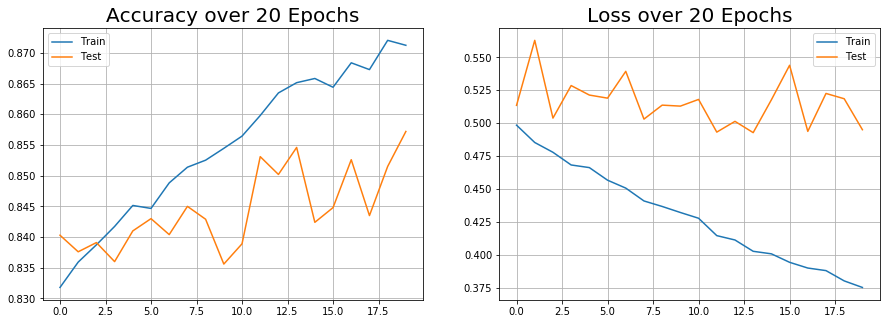

In [72]:
acc, loss, val_acc, val_loss = h.history['acc'], h.history['loss'], h.history['val_acc'], h.history['val_loss']
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(nb_epoch), acc, label='Train')
plt.plot(range(nb_epoch), val_acc, label='Test')
plt.title('Accuracy over ' + str(nb_epoch) + ' Epochs', size=20)
plt.legend()
plt.grid(True)
plt.subplot(122)
plt.plot(range(nb_epoch), loss, label='Train')
plt.plot(range(nb_epoch), val_loss, label='Test')
plt.title('Loss over ' + str(nb_epoch) + ' Epochs', size=20)
plt.legend()
plt.grid(True)
plt.show()

In [68]:
loss, accuracy = model1.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy = %.2f %%     loss = %f" % (accuracy * 100, loss))
loss, accuracy = model1.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy = %.2f %%    loss = %f" % (accuracy * 100, loss))

Training Accuracy = 98.14 %     loss = 0.069331
Testing Accuracy = 77.68 %    loss = 0.879715


## Data Augmentation

In [75]:
aug_gen = ImageDataGenerator(
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = False,  # randomly flip images
)

aug_gen.fit(X_train)
gen = aug_gen.flow(X_train, y_train, batch_size=batch_size)
h = model1.fit_generator(generator=gen, steps_per_epoch=50000//batch_size, epochs=nb_epoch, validation_data=(X_test, y_test))

Epoch 1/20
195/195 [==============================] - 41s - loss: 0.3138 - acc: 0.8951 - val_loss: 0.5025 - val_acc: 0.8599
Epoch 2/20
195/195 [==============================] - 40s - loss: 0.3087 - acc: 0.8966 - val_loss: 0.5120 - val_acc: 0.8656
Epoch 3/20
195/195 [==============================] - 40s - loss: 0.3060 - acc: 0.8968 - val_loss: 0.5991 - val_acc: 0.8631
Epoch 4/20
195/195 [==============================] - 40s - loss: 0.3091 - acc: 0.8962 - val_loss: 0.5032 - val_acc: 0.8625
Epoch 5/20
195/195 [==============================] - 40s - loss: 0.3027 - acc: 0.8991 - val_loss: 0.4655 - val_acc: 0.8607
Epoch 6/20
195/195 [==============================] - 40s - loss: 0.2982 - acc: 0.8996 - val_loss: 0.5265 - val_acc: 0.8672
Epoch 7/20
195/195 [==============================] - 40s - loss: 0.2970 - acc: 0.9002 - val_loss: 0.5160 - val_acc: 0.8638
Epoch 8/20
195/195 [==============================] - 40s - loss: 0.2919 - acc: 0.9029 - val_loss: 0.5511 - val_acc: 0.8685
Epoch 9/

In [76]:
loss, accuracy = model1.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy = %.2f %%     loss = %f" % (accuracy * 100, loss))
loss, accuracy = model1.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy = %.2f %%    loss = %f" % (accuracy * 100, loss))

Training Accuracy = 95.99 %     loss = 0.123636
Testing Accuracy = 86.59 %    loss = 0.540904
